In [175]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [176]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random

from firedrake.petsc import PETSc

In [178]:
# vtk output for Paraview
basename = 'MHDB_'
outfileU = File("/content/drive/MyDrive/MHD-Balmaz/velocity.pvd")
outfileP = File("/content/drive/MyDrive/MHD-Balmaz/Pressure.pvd")
outfileB = File("/content/drive/MyDrive/MHD-Balmaz/Magnetic.pvd")

/usr/local/lib/python3.12/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


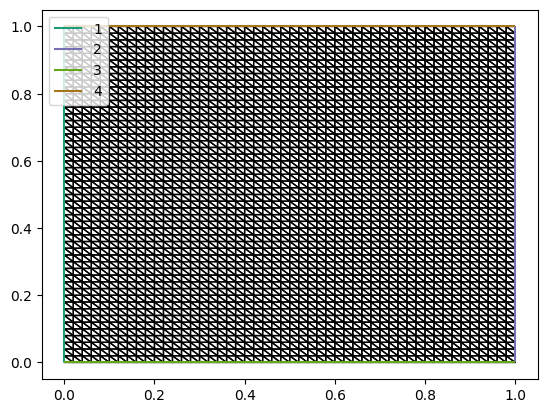

In [179]:
mesh = UnitSquareMesh(50 ,50)
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [180]:
Udiv = FunctionSpace(mesh, 'RT', 2)
Ucurl=FunctionSpace(mesh, 'CG',2) #in 2D nedelec -> P1
Q = FunctionSpace(mesh, 'DG', 1) ## eventualmente P e non DG
W=MixedFunctionSpace([Udiv, Udiv, Q, Ucurl, Ucurl, Ucurl])


+ Spazi di RT sono per costruzione vettoriali gia, ed hanno di default:
$$u \cdot \hat{n}$$
usando quindi una $\texttt{DirichletBC(...,constant(0),())}$ impongo automaticamente che
$$u\cdot \hat{n}=0$$

+ Spazi di Nedelec sono anche gia vettoriali di default:
Hanno di default che
$$u\times \hat{n}$$
quindi imporre una BC di Dirichlet qua implica avere
$$u\times \hat{n}=0$$

In [181]:
x=SpatialCoordinate(mesh)

def perp(vec):
  return as_vector((-vec[1],vec[0]))

# IC: as_vector -> func(W)
u_ic=as_vector((x[1]*exp(-4*(x[0]**2+x[1]**2)),\
               -x[0]*exp(-4*(x[0]**2+x[1]**2))))

B_ic_onZ=as_vector((-x[0]*(1-x[1]**2)*sin(pi*x[1]),\
                    -(1-x[0]**2)*x[1]*sin(pi*x[0])))

# IC 2

xc = Constant(0.5)
yc = Constant(0.5)

r  = sqrt((x[0] - xc)**2 + (x[1] - yc)**2)
r0 = Constant(0.2)   # raggio della corona
sigma = Constant(0.06)  # spessore (più piccolo = anello più sottile)

g = exp(-((r - r0)**2) / (2*sigma**2))  # envelope anulare
u_ic_2 = g * as_vector((-(x[1] - yc), (x[0] - xc)))

# BC

bc_v_L=DirichletBC(W.sub(0),Constant((0,0)),(1,2,3,4))
bc_B_L=DirichletBC(W.sub(1),Constant((0,0)),(1,2,3,4))
bc_w = DirichletBC(W.sub(3), Constant(0.0), (1,2,3,4))
bc_J = DirichletBC(W.sub(4), Constant(0.0), (1,2,3,4))
bc_E = DirichletBC(W.sub(5), Constant(0.0), (1,2,3,4))

bcsU=(bc_v_L)
bcsB=(bc_B_L)
bcs=(bcsU,bcsB, bc_w,bc_J,bc_E)
dt=0.01

TO DO: Rendere perp tutti i cross/curl che stanno su Z


In [182]:
def weak_form_NSB(u,B,p,w,J,E,v,C,q,z,K,F,dt,u_old,B_old):
  """
  v,C,q        = TestFunctions
  u,B,p          = TrialFunctions
  u_old, B_old = Functions
  """

  j = as_matrix([[0, -1],
               [1,  0]])

  u_perp = dot(j,u_old)
  w_vec = w*u_perp

  B_perp= dot(j , B_old)
  j_vec=J*B_perp


  """cross1 = w[0]*u_old[1] - w[1]*u_old[0]
  cross_vec1 = as_vector((cross1, cross1))

  cross2=J[0]*B_old[1]-J[1]*B_old[0]
  cross_vec2=as_vector((cross2,cross2))

  cross3=u[0]*B_old[1]-u[1]*B_old[0]
  cross_vec3=as_vector((cross3,cross3))"""

  a= +1/dt*inner(u,v)*dx\
    +inner(w_vec, v)*dx\
    -inner(j_vec, v)*dx\
    -p*div(v)*dx\
    +1/dt*dot(B, C)*dx\
    +dot(curl(E), C)*dx\
    +q*div(u)*dx\
    +inner(w, z)*dx\
    -inner(u, curl(z))*dx\
    +inner(J, K)*dx\
    -inner(B, curl(K))*dx\
    +inner(E, F)*dx\
    +(u[0]*B_old[1] - u[1]*B_old[0])* F*dx


  L=1/dt*dot(u_old,v)*dx\
    +1/dt*dot(B_old,C)*dx
  return a,L


In [183]:
"""j = as_matrix([[0, -1],
               [1,  0]])


expr =j * uh_old
print(expr.ufl_shape) #check dimensions"""

'j = as_matrix([[0, -1],\n               [1,  0]])\n\n\nexpr =j * uh_old\nprint(expr.ufl_shape) #check dimensions'

In [184]:
u,B,p,w,J,E=TrialFunctions(W)
v,C,q,z,K,F=TestFunctions(W)

In [185]:
Wh=Function(W)

uh,Bh,ph,wh,Jh,Eh=Wh.subfunctions

uh.interpolate(u_ic_2)
Bh.interpolate(B_ic_onZ)
ph.interpolate(Constant(0))
"""wh.interpolate(Constant(1))
Jh.interpolate(Constant(1))
Eh.interpolate(Constant(1))"""

uh_old=Function(W[0])
Bh_old=Function(W[1])
ph_old=Function(W[2])
ph_mean=Function(W[2])

uh_old.assign(uh)
ph_old.assign(ph)
Bh_old.assign(Bh)


Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7d82d8b3e540>, FiniteElement('Raviart-Thomas', triangle, 2), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1795)), 3755)

In [186]:
# vtk output for Paraview
uh_old.rename("Velocity")   # this names will be used in Paraview
ph_old.rename("Pressure")
Bh_old.rename("Magnetic")
outfileU.write(uh_old)
outfileP.write(ph_old)
outfileB.write(Bh_old)

In [187]:
param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}

param_gmres = {'ksp_type': 'gmres',
         'ksp_rtol': 1e-6,
         'ksp_max_it': 2000 ,
         "ksp_monitor": None }

In [188]:
nsp = MixedVectorSpaceBasis(W, [W.sub(0), VectorSpaceBasis(constant=True)])

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


In [189]:
a,L=weak_form_NSB(u,B,p,w,J,E,v,C,q,z,K,F,dt,uh_old,Bh_old)
problem=LinearVariationalProblem(a,L,Wh,bcs=bcs)
solver=LinearVariationalSolver(problem,solver_parameters=param_gmres)
solver.solve()

      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 1.708032474026e+02
      1 KSP Residual norm 3.657160179411e+00
      2 KSP Residual norm 1.594871149804e-08


Text(0.5, 1.0, 'Magnetic Field')

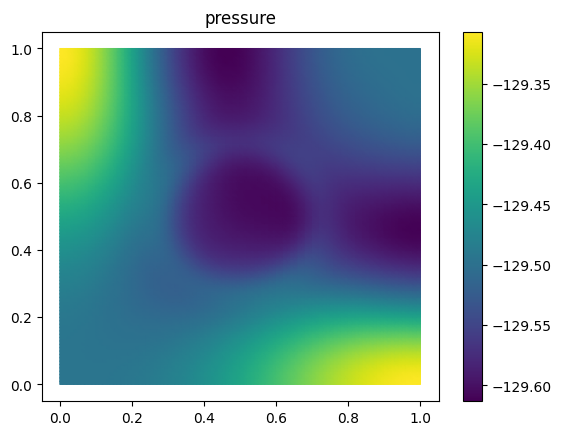

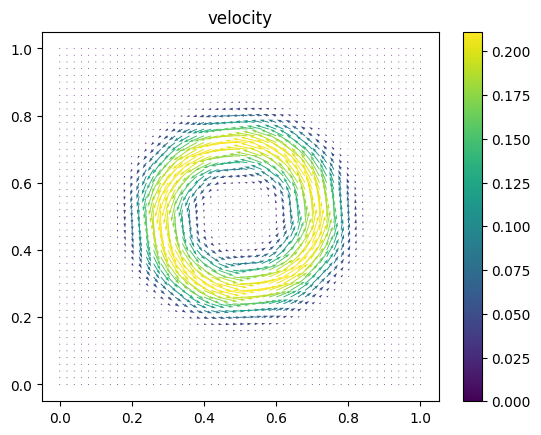

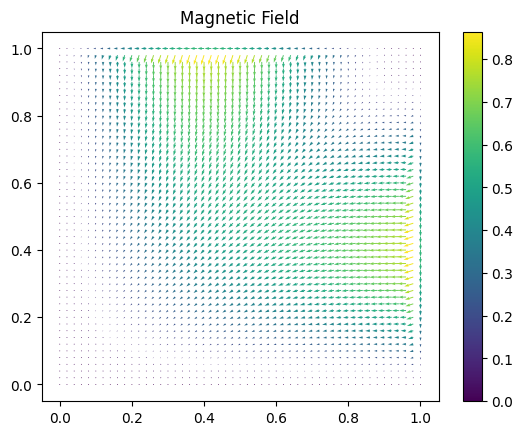

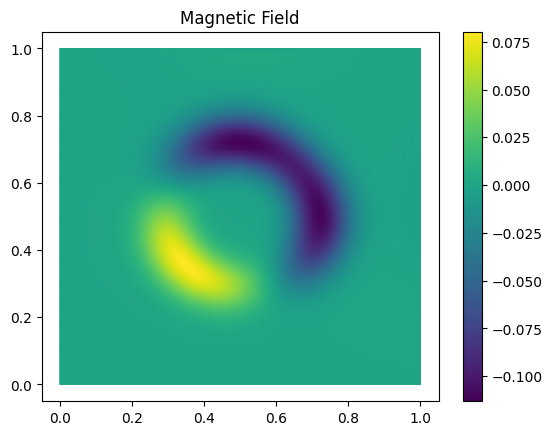

In [190]:
fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')
fig, ax = plt.subplots()
col = quiver(Bh, axes=ax)
plt.colorbar(col)
plt.title('Magnetic Field')
fig, ax = plt.subplots()
col = tripcolor(Eh, axes=ax)
plt.colorbar(col)
plt.title('Magnetic Field')


In [191]:
def p_mean_(ph):
  area = assemble(Constant(1.0) * dx(domain=mesh))   # area del dominio (2D)
  p_mean = assemble(ph * dx(domain=mesh))
  return p_mean


p_mean=p_mean_(ph)
#ph_mean.assign(p_mean)
#print(type(ph), type(ph_mean))
print(type(ph-1))

<class 'ufl.algebra.Sum'>


In [192]:
T=0.5
t_vec = np.arange(0, T+0.1*dt, dt)  # T+0.1*dt to include also T: range/arange exclude the upper bound of the range

for ii in range(1, len(t_vec)):     # start from 1 to skip t=0
    t = t_vec[ii]
    print('Time = ', t)

    solver.solve()
    uh,Bh,ph,wh,Jh,Eh=Wh.subfunctions
    p_mean=p_mean_(ph)
    ph_mean.assign(p_mean)
    deltap=ph-ph_mean
    ph=Function(W[2])
    ph.assign(deltap)
    print(type(ph))
    print('||u||_L2',errornorm(uh,uh_old,'L2')/norm(uh_old,'L2'),'||p||_L2',errornorm(ph,ph_old,'L2')/norm(ph_old,'L2'),'||B||_L2',errornorm(Bh,Bh_old,'L2')/norm(Bh_old,'L2'))


    uh.rename("Velocity")
    ph.rename("Pressure")
    Bh.rename("Magnetic")

    # Post-processing
    outfileU.write(uh_old, time=t)
    outfileP.write(ph_old, time=t)
    outfileB.write(Bh_old, time=t)



    uh_old.assign(uh)
    Bh_old.assign(Bh)
    ph_old.assign(ph) # valutare se aggiornalo prima del campo magnetico

Time =  0.01
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 4.916699859587e+00
      1 KSP Residual norm 4.499502897456e+00
      2 KSP Residual norm 1.104381377204e-08
<class 'firedrake.function.Function'>
||u||_L2 0.02311406228244745 ||p||_L2 inf ||B||_L2 0.08254422108483926


/tmp/ipython-input-3462047790.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  print('||u||_L2',errornorm(uh,uh_old,'L2')/norm(uh_old,'L2'),'||p||_L2',errornorm(ph,ph_old,'L2')/norm(ph_old,'L2'),'||B||_L2',errornorm(Bh,Bh_old,'L2')/norm(Bh_old,'L2'))


Time =  0.02
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 3.446249895751e+01
      1 KSP Residual norm 1.945258961358e+01
      2 KSP Residual norm 2.293860304965e-10
<class 'firedrake.function.Function'>
||u||_L2 0.02444648320552431 ||p||_L2 0.04391265926074762 ||B||_L2 0.009003336594586265
Time =  0.03
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 2.791445094721e+01
      1 KSP Residual norm 2.076903509410e-01
      2 KSP Residual norm 1.243115361516e-09
<class 'firedrake.function.Function'>
||u||_L2 0.026065184523658746 ||p||_L2 0.0189358857874587 ||B||_L2 0.0087835216475256
Time =  0.04
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 2.577636004138e+01
      1 KSP Residual norm 6.443202838521e-01
      2 KSP Residual norm 5.585833989683e-08
<class 'firedrake.function.Function'>
||u||_L2 0.02817508793887649 ||p||_L2 0.020018101711886272 ||B||_L2 0.008511319945514819
Time =  0.05
      Residual norms for firedr

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 820, in send
    msg = self.msg(
          ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 661, in msg
    header = self.msg_header(msg_type) if header is None else header
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 644, in msg_header
    return msg_header(self.msg_id, msg_type, self.username, self.session)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 275, in msg_header
    date

Time =  0.42
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 1.874843379868e+01
      1 KSP Residual norm 1.215101206715e+00
      2 KSP Residual norm 4.753988843152e-10
<class 'firedrake.function.Function'>
||u||_L2 0.04027731512127952 ||p||_L2 0.02454451753245375 ||B||_L2 0.005393340471921764
Time =  0.43
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 1.880587805550e+01
      1 KSP Residual norm 1.399994599321e+00
      2 KSP Residual norm 2.024443752736e-10
<class 'firedrake.function.Function'>
||u||_L2 0.040409572783079675 ||p||_L2 0.021402109604939507 ||B||_L2 0.005298370392358979
Time =  0.44
      Residual norms for firedrake_8_ solve.
      0 KSP Residual norm 1.906664378005e+01
      1 KSP Residual norm 2.587210545113e+00
      2 KSP Residual norm 1.699705496844e-10
<class 'firedrake.function.Function'>
||u||_L2 0.04048215105945366 ||p||_L2 0.019143801278930787 ||B||_L2 0.005213157188637118
Time =  0.45
      Residual norms for fi

Text(0.5, 1.0, 'Magnetic Field')

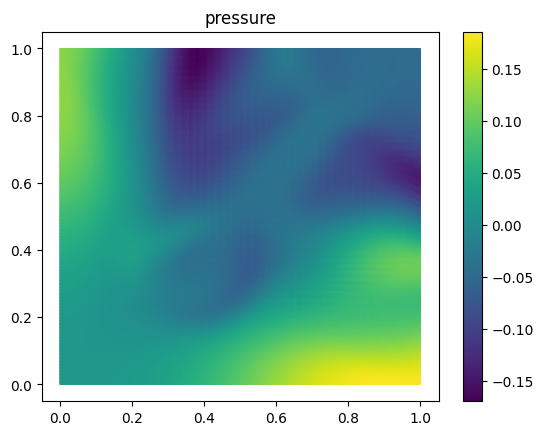

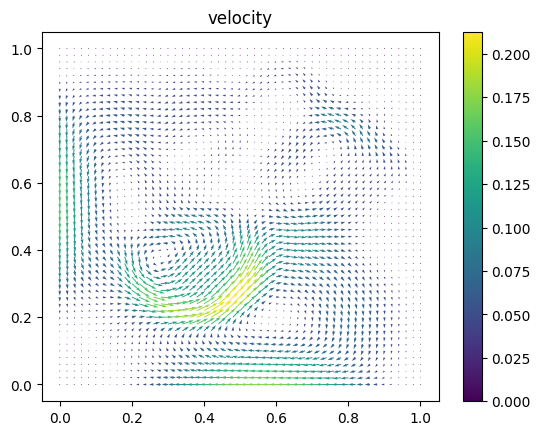

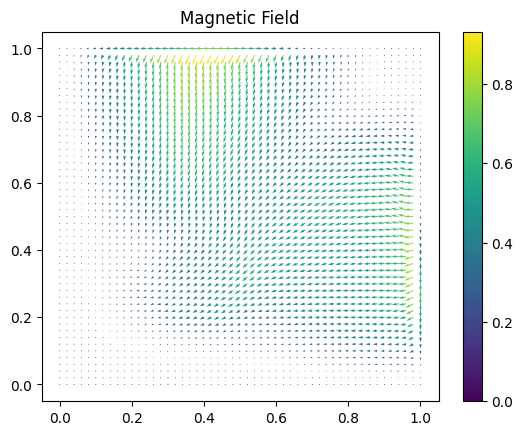

In [193]:
fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')
fig, ax = plt.subplots()
col = quiver(Bh, axes=ax)
plt.colorbar(col)
plt.title('Magnetic Field')